1) Import neccessary libraries and dependencies and setting a seed for reproducibility of experiments and results

In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import RDLogger 
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from utils import *
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import from_smiles
from dect.directions import generate_uniform_directions 
from dect.ect import compute_ect_edges
import torch
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm
import time
from utils import seed_set

In [2]:
seed_set()

Differences between: 

- cross_val_score: calculate score for each CV split (In this notebook we use it)
- cross_validate: calculate one or more scores and timings for each CV split

[More info.](https://datascience.stackexchange.com/questions/28441/what-is-the-difference-between-cross-validate-and-cross-val-score)

2) Load the dataset

In [4]:
df = pd.read_csv('data/datasetCSV/ADRA1A.csv')
print(f"Loaded {df.shape[0]} molecules from csv")
df.head(5)

Loaded 1959 molecules from csv


,dataset,smiles,target
0,ADRA1A,COC(=O)C1=C(C)NC(=O)N(C(=O)NCCC[NH+]2CCN(c3ccc...,-4.605170
1,ADRA1A,COc1cc2[nH+]c(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC,-4.605170
2,ADRA1A,COC(=O)C1=C(C)NC(=O)N(C(=O)NCCC[NH+]2CCN(c3ccc...,-3.912023
3,ADRA1A,CC(C)Oc1ccccc1N1CCN(Cc2cccc(C(=O)N3CCCCC3)c2)CC1,-3.912023
4,ADRA1A,CCOc1ccccc1OCC[NH2+][C@H](C)Cc1ccc(OC)c(S(N)(=...,-3.540459


3) Create a grid of combinations of directions and resolutions numbers for computing the ECT.

In [15]:
# thetas_list = [10*(i+1) for i in range(10)]
# res_list = [10*(i+1) for i in range(10)]
thetas_list = [10,20,40,60,80,100, 140, 180, 200]
res_list = [10,20,40,60,80,100, 140, 180, 200]
param_grid = [(t, r) for t in thetas_list for r in res_list]

4) Compute the ect for each combination and compute cross validation for obtain scores.

In [ ]:
graph_list = []
for i, smile in tqdm(enumerate(df['smiles']), total=len(df), leave=True, desc="Computing molecules graph from smiles"):
  g = from_smiles(smile)
  g.x = g.x.float()
  graph_list.append(g) 
  
print(f"Loaded {len(df['smiles'])} molecules from smiles")

scores = []
for iter, (theta, res) in tqdm(enumerate(param_grid), total=len(param_grid), leave=True, desc=f"Computing ECT for different number of directions and resolutions"):
    inicio = time.time()
    graph_list_ect = []
    v = generate_uniform_directions(num_thetas=theta,d=9,seed=0,device='cpu') #device cpu or cuda as in torch
    for g in graph_list:
        ect = compute_ect_edges(g.x, g.edge_index, v=v, radius=1, resolution=res, scale=500)
        new_g = g.clone()  # evita modificar el grafo original
        new_g.ect = ect
        graph_list_ect.append(new_g)
    X=[]
    y=[]
    for i in range(len(graph_list_ect)):
        X.append(graph_list_ect[i].ect.detach().squeeze().numpy().T.flatten())
        y.append(df['target'][i])
    scaler = StandardScaler()
    scaler.fit(X)
    Xscaled = scaler.transform(X)
    y = np.array(y)
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.01,
        max_depth=5,
        random_state=42
    )
    scoring = {
        'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
        'r2': 'r2',
    }
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    results = cross_validate(xgb_model, Xscaled, y, scoring=scoring, cv=cv, return_train_score=True)
    rmse = results["test_rmse"].mean()
    rmse_std = results["test_rmse"].std()
    r2_score = results["test_r2"].mean()
    r2_std = results["test_r2"].std()
    fin = time.time()
    timeSeconds= fin - inicio
    scores.append((theta, res, rmse, rmse_std, r2_score, r2_std, timeSeconds))
    print(f" Done for theta: {theta}, res: {res}; in {timeSeconds:.2f} seconds obtaining an RMSE: {rmse:.4f}")

Computing molecules graph from smiles:   0%|          | 0/1959 [00:00<?, ?it/s]

Loaded 1959 molecules from smiles


Computing ECT for different number of directions and resolutions:   0%|          | 0/36 [00:00<?, ?it/s]

 Done for theta: 10, res: 10; in 1.45 seconds obtaining an RMSE: 2.3376
 Done for theta: 10, res: 20; in 2.08 seconds obtaining an RMSE: 2.3165
 Done for theta: 10, res: 40; in 3.40 seconds obtaining an RMSE: 2.3037
 Done for theta: 10, res: 60; in 5.48 seconds obtaining an RMSE: 2.3053
 Done for theta: 10, res: 80; in 6.57 seconds obtaining an RMSE: 2.3011
 Done for theta: 10, res: 100; in 8.71 seconds obtaining an RMSE: 2.2938
 Done for theta: 20, res: 10; in 1.80 seconds obtaining an RMSE: 2.3422
 Done for theta: 20, res: 20; in 2.89 seconds obtaining an RMSE: 2.3277
 Done for theta: 20, res: 40; in 5.45 seconds obtaining an RMSE: 2.3247
 Done for theta: 20, res: 60; in 8.78 seconds obtaining an RMSE: 2.3267
 Done for theta: 20, res: 80; in 11.17 seconds obtaining an RMSE: 2.3215
 Done for theta: 20, res: 100; in 16.44 seconds obtaining an RMSE: 2.3175
 Done for theta: 40, res: 10; in 3.51 seconds obtaining an RMSE: 2.2641
 Done for theta: 40, res: 20; in 6.79 seconds obtaining an R

5) We analyse and visualize how both parameters influence the model performance (error), using a heatmap.

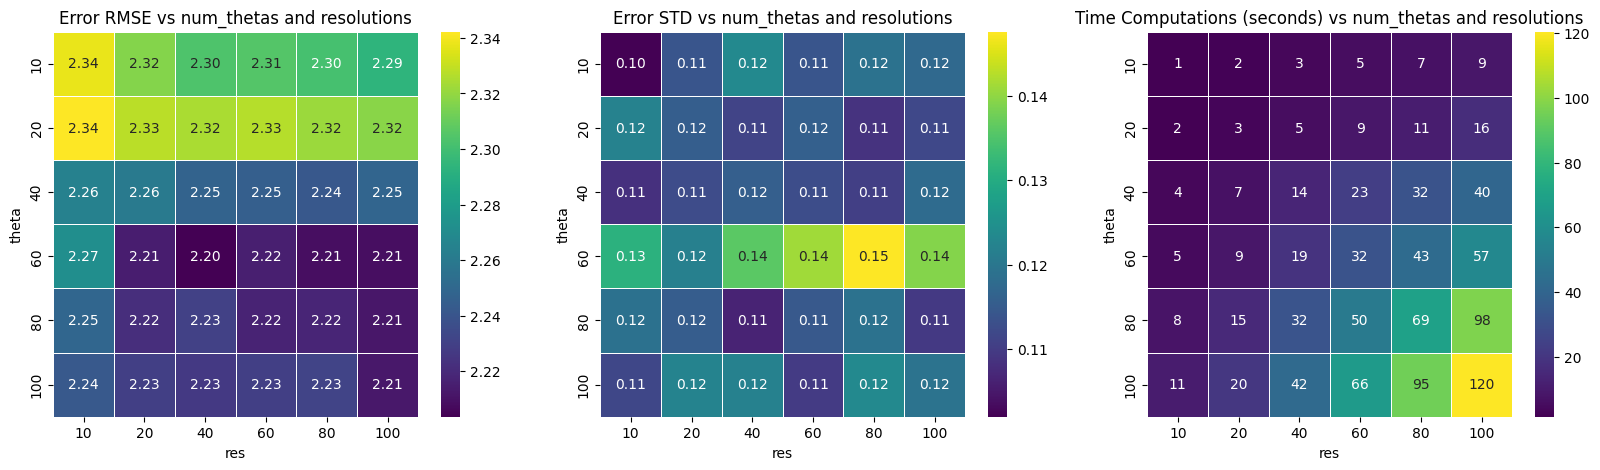

In [ ]:
if 'scores' in locals() or 'scores' in globals():
    df_scores = pd.DataFrame(scores, columns=["theta", "res", "rmse","rmse_std","r2", "r2_std", "timeSeconds"])
else:
    print("No scores found")

pivotRMSE = df_scores.pivot(index="theta", columns="res", values="rmse")
pivotSTD = df_scores.pivot(index="theta", columns="res", values="rmse_std")
pivotTime = df_scores.pivot(index="theta", columns="res", values="timeSeconds")

fig, axes = plt.subplots(1,3, figsize=(20, 5))
sns.heatmap(pivotRMSE, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[0])
axes[0].set_title("Error RMSE vs num_thetas and resolutions")
sns.heatmap(pivotSTD, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[1])
axes[1].set_title("Error RMSE STD vs num_thetas and resolutions")
sns.heatmap(pivotTime, annot=True, cmap="viridis", linewidth=.5, fmt=".0f",ax=axes[2])
axes[2].set_title("Time Computations (seconds) vs num_thetas and resolutions")
plt.show()

if 'scores' in locals() or 'scores' in globals():
    df_scores = pd.DataFrame(scores, columns=["theta", "res", "rmse","rmse_std","r2", "r2_std", "timeSeconds"])
    df_scores.to_csv("results/scoresRelationECTparamwitherror.csv", index=False)
else:
    df_scores = pd.read_csv("results/scoresRelationECTparamwitherror.csv")

pivotRMSE = df_scores.pivot(index="theta", columns="res", values="rmse")
pivotSTD = df_scores.pivot(index="theta", columns="res", values="rmse_std")
pivotTime = df_scores.pivot(index="theta", columns="res", values="timeSeconds")

fig, axes = plt.subplots(1,3, figsize=(20, 5))
sns.heatmap(pivotRMSE, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[0])
axes[0].set_title("Error RMSE vs num_thetas and resolutions")
sns.heatmap(pivotSTD, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[1])
axes[1].set_title("Error RMSE STD vs num_thetas and resolutions")
sns.heatmap(pivotTime, annot=True, cmap="viridis", linewidth=.5, fmt=".0f",ax=axes[2])
axes[2].set_title("Time Computations (seconds) vs num_thetas and resolutions")
plt.show()


pivotRMSE = df_scores.pivot(index="theta", columns="res", values="r2")
pivotSTD = df_scores.pivot(index="theta", columns="res", values="r2_std")

fig, axes = plt.subplots(1,3, figsize=(20, 5))
sns.heatmap(pivotRMSE, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[0])
axes[0].set_title("Error RMSE vs num_thetas and resolutions")
sns.heatmap(pivotSTD, annot=True, cmap="viridis", linewidth=.5, fmt=".2f",ax=axes[1])
axes[1].set_title("Error RMSE STD vs num_thetas and resolutions")
sns.heatmap(pivotTime, annot=True, cmap="viridis", linewidth=.5, fmt=".0f",ax=axes[2])
axes[2].set_title("Time Computations (seconds) vs num_thetas and resolutions")
plt.show()

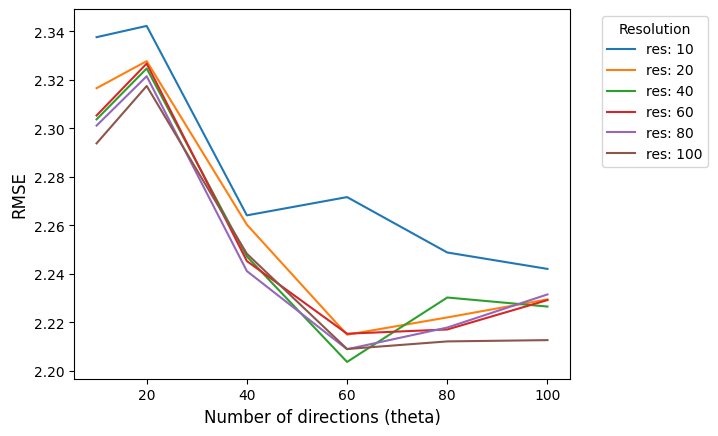

In [ ]:
np.unique(df_scores['res'])
for i in np.unique(df_scores['res']):
    df_scores.loc[df_scores['res'] == i].sort_values(by='rmse', ascending=True).head(5)
    plt.plot(df_scores.loc[df_scores['res'] == i]['theta'], df_scores.loc[df_scores['res'] == i]['rmse'], label=f"res: {i}")

plt.xlabel('Number of directions (theta)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend(title='Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

np.unique(df_scores['res'])
for i in np.unique(df_scores['res']):
    df_scores.loc[df_scores['res'] == i].sort_values(by='r2', ascending=True).head(5)
    plt.plot(df_scores.loc[df_scores['res'] == i]['theta'], df_scores.loc[df_scores['res'] == i]['r2'], label=f"res: {i}")

plt.xlabel('Number of directions (theta)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend(title='Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Boxplot to show error distribution for each number of direction and resolution

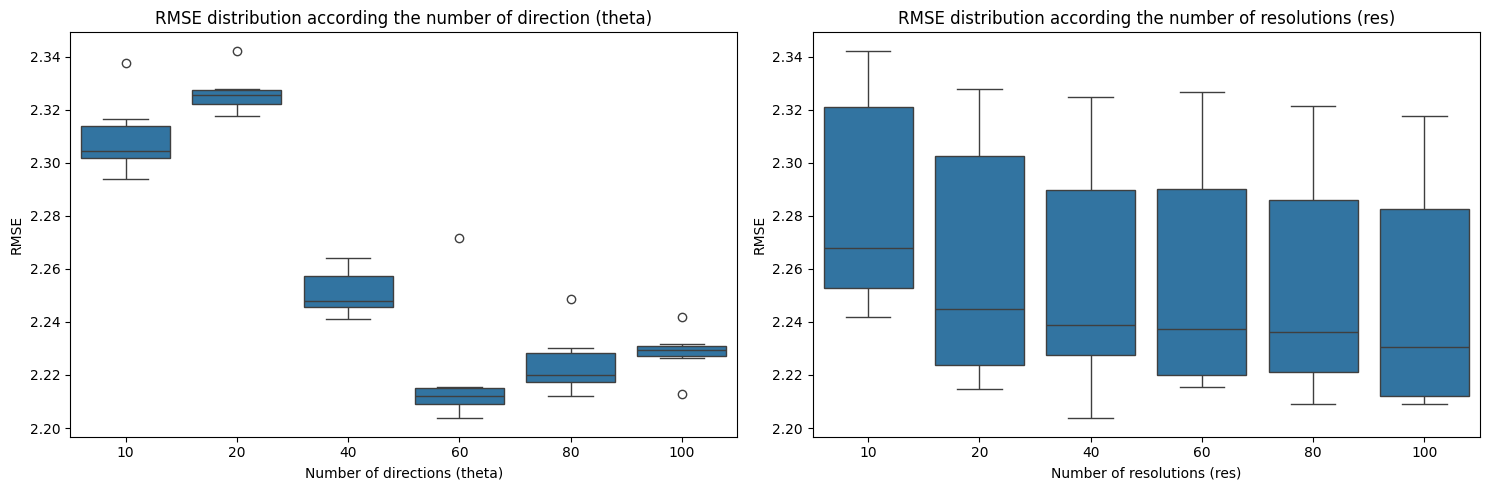

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="theta", y="rmse", data=df_scores, ax=axes[0])
axes[0].set_title("RMSE distribution according the number of direction (theta)")
axes[0].set_xlabel("Number of directions (theta)")
axes[0].set_ylabel("RMSE")

sns.boxplot(x="res", y="rmse", data=df_scores, ax=axes[1])
axes[1].set_title("RMSE distribution according the number of resolutions (res)")
axes[1].set_xlabel("Number of resolutions (res)")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()

Correlation analysis

In [11]:
corr_pearson_theta = df_scores['theta'].corr(df_scores['rmse'], method='pearson')
corr_spearman_theta = df_scores['theta'].corr(df_scores['rmse'], method='spearman')
corr_pearson_res = df_scores['res'].corr(df_scores['rmse'], method='pearson')
corr_spearman_res = df_scores['res'].corr(df_scores['rmse'], method='spearman')

print(f"Correlación Pearson (theta vs rmse): {corr_pearson_theta:.4f}")
print(f"Correlación Spearman (theta vs rmse): {corr_spearman_theta:.4f}")
print(f"Correlación Pearson (res vs rmse): {corr_pearson_res:.4f}")
print(f"Correlación Spearman (res vs rmse): {corr_spearman_res:.4f}")

Correlación Pearson (theta vs rmse): -0.6552
Correlación Spearman (theta vs rmse): -0.6554
Correlación Pearson (res vs rmse): -0.0755
Correlación Spearman (res vs rmse): -0.0879
